In [15]:
# Setup

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [16]:
# Using the Embedding layer

embedding_layer = layers.Embedding(1000, 5) 

result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.shape

TensorShape([2, 3, 5])

In [17]:
# Learning embeddings from scratch
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

In [18]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

In [22]:
train_batches = (
    train_data.shuffle(1000)
    .padded_batch(10, padded_shapes=([None],[])))

test_batches = (
    test_data.shuffle(1000)
    .padded_batch(10, padded_shapes=([None],[])))

# 10개마다 길이가 같도록 만듦

In [23]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

#[3209, 1493,    5, ..., 7961, 2255, 7975], 가 제일 긴 바람에 나머지 얘들이 0으로 채워짐

array([[ 147,    1, 5302, ...,    0,    0,    0],
       [3209, 1493,    5, ..., 7961, 2255, 7975],
       [  62,    9, 4040, ...,    0,    0,    0],
       ...,
       [1071,    2,   63, ...,    0,    0,    0],
       [  12,   18, 1401, ...,    0,    0,    0],
       [ 147,    1, 2672, ...,    0,    0,    0]])

In [24]:
# Create a simple model
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Compile and train the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.5090 - accuracy: 0.6916 - val_loss: 0.3741 - val_accuracy: 0.8350
Epoch 2/10
2500/2500 [==============================] - 6s 2ms/step - loss: 0.2838 - accuracy: 0.8811 - val_loss: 0.3945 - val_accuracy: 0.8550
Epoch 3/10
2500/2500 [==============================] - 6s 2ms/step - loss: 0.2267 - accuracy: 0.9094 - val_loss: 0.3637 - val_accuracy: 0.8750
Epoch 4/10
2500/2500 [==============================] - 6s 2ms/step - loss: 0.1968 - accuracy: 0.9244 - val_loss: 0.4101 - val_accuracy: 0.8550
Epoch 5/10
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1773 - accuracy: 0.9328 - val_loss: 0.3068 - val_accuracy: 0.8900
Epoch 6/10
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1586 - accuracy: 0.9404 - val_loss: 0.4383 - val_accuracy: 0.8500
Epoch 7/10
2500/2500 [==============================] - 6s 2ms/step - loss: 0.1452 - accuracy: 0.9476 - val_loss: 0.3407 - val_accuracy:

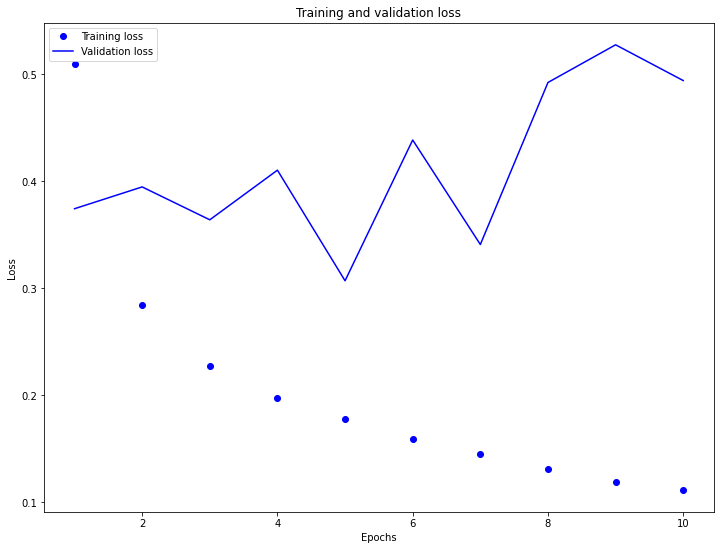

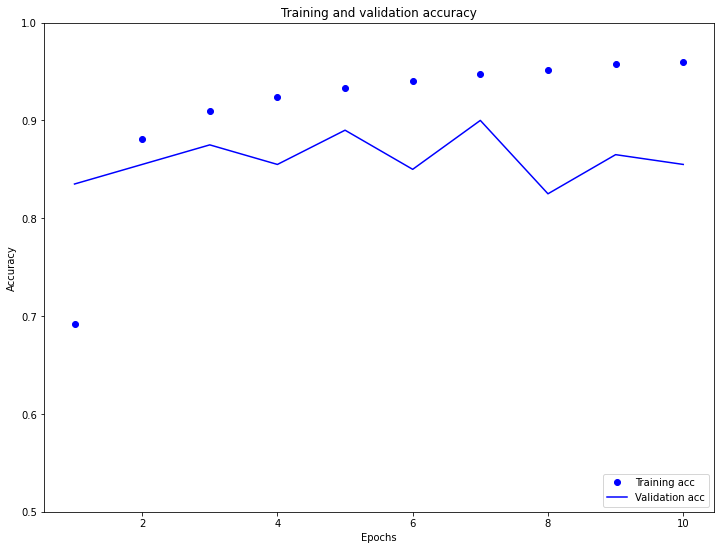

In [26]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [27]:
# Retrieve the learned embeddings
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


In [28]:
import io

# 임베딩이 어떻게 생겼는지 확인할 수 있음
encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [29]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')